# Summary

Grab data from AnnData object and use it to create a graph pkl

## Background

Data can be represented in a more complete way by utilizing edge features in graph attention networks and modifying the architecture based on empirical results from 2021 

## Objective

Use self-supervised learning to learn graphical representations of data and harness edge features in improving performance of predictive tasks

## Methods

GAT, edge features, self-supervised learning, representation learning, healthcare application, single-cell transcriptomic data

- use batch labels from dataset, train GAT to get edge coefficients from preds of those labels, use this for "batch effect correction" in the model, either by penalizing reliance on these edge features, or controlling for them in the final model 
- 

In [1]:
%matplotlib inline
%load_ext memory_profiler

import os
import time
import datetime
import sys
import pickle
import scanpy as sc
from scipy import sparse
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

sc.settings.verbosity=2

In [2]:
import glob
dfp = '/home/ngr4/project/scnd/data'
glob.glob(os.path.join(dfp, '*h5ad'))

['/home/ngr4/project/scnd/data/mouse_220805.h5ad',
 '/home/ngr4/project/scnd/data/mouse_210726.h5ad']

In [3]:

import scanpy as sc
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import random
from scipy import sparse
import pickle

import torch
import torch.nn as nn
import torch.functional as F

from torch_geometric.data import Data, ClusterData, ClusterLoader


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

/gpfs/ysm/project/dijk/ngr4/conda_envs/py38dev/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Data

## check and modify

From Leon:
correct genotype

·   5wk WT= 7202, 72921, 72922

·   5wk SCA1= 7294, 72931, 72932

·   12wk wild-type: 22018, 2061, 2062

·   12wk SCA1: 22019, 2063, 2065

·   18wk WT: 6569, 65701, 65702

·   18wk SCA1: 6571, 65731, 65732

·   24wk wild-type: 1974, 2020, 20202

·   24wk SCA1: 1589, 2021, 20212

·   30wk WT: 5812, #5822, 58232

·   30wk SCA1: #58231, 58241, 58242


58231 and 5822 have been assigned WT and SCA1 originally, respectively

In [14]:
# load data
adata = sc.read('/home/ngr4/project/scnd/data/mouse_220805.h5ad')

In [5]:
# brief chk
# original
dt = adata.obs.loc[:, ['batch', 'genotype_crct', 'timepoint']].drop_duplicates().sort_values(by=['timepoint', 'genotype_crct'])
dt.groupby(['timepoint', 'genotype_crct'])['batch'].apply(list)

timepoint  genotype_crct
5wk        SCA1              [7294, 72931, 72932]
           WT                [7202, 72921, 72922]
12wk       SCA1               [22019, 2063, 2065]
           WT                 [22018, 2061, 2062]
18wk       SCA1              [6571, 65731, 65732]
           WT                [6569, 65701, 65702]
24wk       SCA1               [1589, 2021, 20212]
           WT                 [1974, 2020, 20202]
30wk       SCA1             [58231, 58241, 58242]
           WT                 [5812, 58232, 5822]
Name: batch, dtype: object

/gpfs/ysm/project/dijk/ngr4/conda_envs/py38dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50
    finished (0:01:05)


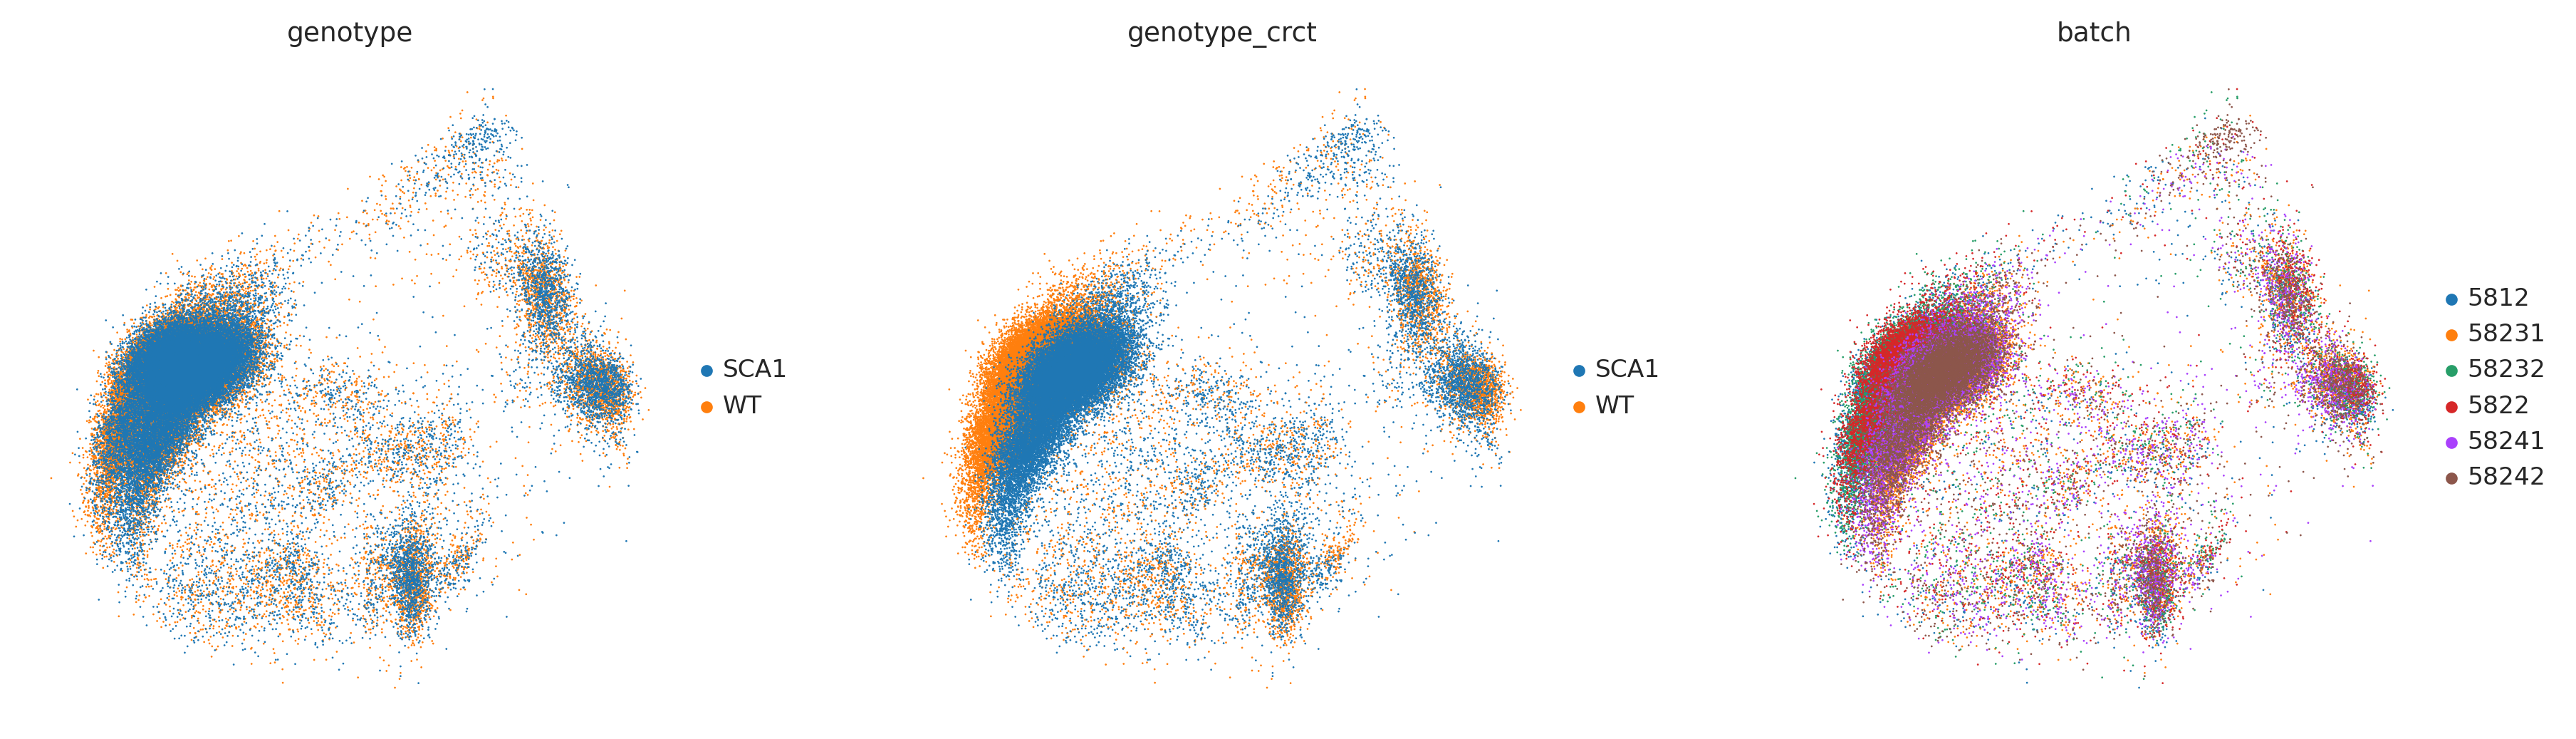

In [6]:
# brief chk
tdata = adata[adata.obs['timepoint']=='30wk'].copy()
sc.tl.pca(tdata)
sc.pl.pca_scatter(tdata, color=['genotype', 'genotype_crct', 'batch'], save='_batch_gtpye_crct.png')

### add genotime label

In [9]:
adata.obs['genotime_crct'] = adata.obs['genotype_crct'].astype('str') + '_' + adata.obs['timepoint'].astype(str)

In [10]:
adata.write('/home/ngr4/project/scnd/data/mouse_220805.h5ad')

... storing 'genotime_crct' as categorical


# Pre-process data

## summary

The data needs to be processed in order to prepare for machine learning. First, we split the data into train/test/validation splits and then we uniformly incorporate the data into PyTorch Geometric for geometric deep learning applications. This is sometimes referred to as `h5ad2graphpkl`

In [4]:


# data
## data loader 
class pp_singlecell_data():
    # from adata (scanpy.AnnData obj)
    def __init__(self, adata_filename, label_colname, pkl_out=None, adata_out=None, 
                 return_joint_adata=True, return_adatas=False, return_pgdata=True):
        '''Load single-cell data, add splits, and prep for torch loading
        
        TODO:
          1. check normalization 
          2. add options for similar pre-process by pointing to cellranger
          3. if load from datapkl, don't go through slow pp steps
        
        Arugments:
          adata_filename (str): full filename to sc.AnnData object
          label_colname (str or list): column name in adata.obs slot to turn into class labels. If 
            label_colname exists, keep int class labels. Last label colname in list will get used as target 
          adata_out (str) : (optional, Default=None) specify the filepath to write modified adata to this filename
          return_joint_adata (bool): (optional, Default=False) if you want just the full adata back for plotting, etc.
          return_* (bool): (optional, Default=True) specify whether you want the data to return these things. E.g, if you're only 
            interested in plotting adata things, you don't need to create pytorch-geometric objects. And if you're only running models
            you don't need to store all the adata junk
          pkl_out (str): (optional, Default=None) if not none, filepath to dump all pp'ed data objs. Overwirtes return options
          
        '''
        self.adata_filename = adata_filename
        self.label_colname = label_colname
        self.pkl_out = pkl_out
        self.adata_out = adata_out
        self.return_joint_adata = return_joint_adata
        self.return_adatas = return_adatas
        self.return_pgdata = return_pgdata
        
        tic = time.time()
        
        print('Loading single-cell data for modeling')
        adata = sc.read(adata_filename)
        
        if True:
            # clean adata to minimize pkl size
            del adata.obsm
            del adata.layers
            del adata.uns
            del adata.obsp
        
        print('  ... checking for split')
        if 'split' not in adata.obs.columns.to_list() : # otherwise, assume splits are good
            print('        adding 70/15/15 train/test/val split')
            if adata_out is None:
                warnings.warn('Splits added to adata.obs. For reproducibility, save adata by specifying adata_out=filename_out.', UserWarning)
            adata = self.add_splits(adata, p_val=0.15, p_test=0.15)
        
        print('  ... checking for {} presence in adata.obs'.format(label_colname))
        # encode label via alphabetization for eventual torch --> LongTensor
        if isinstance(self.label_colname, list):
            for label_ in self.label_colname:
                adata = self.label_encoding(adata, label_colname=label_)
        else:
            adata = self.label_encoding(adata, label_colname=self.label_colname)
        
        if self.return_joint_adata or self.pkl_out is not None:
            if False:
                # recalculate the neighbor graph?
                print('  ... recalculating full adata graph')
                adata = self.graph_pp(adata)
            self.adata = adata
            
        if self.adata_out is not None:
            print('\n... saving adata:')
            adata.write(adata_out)
            print('      written to {}'.format(adata_out))
        
        print('  ... generating graphs per split after {:.1f}-s'.format(time.time() - tic))
        # no need to save adata graphs
        adatas = {}
        for split in adata.obs['split'].unique():
            tic_graph_pp_split = time.time()
            print('  ...   graph_pp() split for {}'.format(split))
            adatas[split] = self.graph_pp(adata[adata.obs['split']==split, :])  
            print('  ...     finished in {:.2f}-s'.format(time.time() - tic_graph_pp_split))
            
        if self.return_adatas:
            self.adatas = adatas
            
        # get pytorch geometric objects (pgos) per split
        if self.return_pgdata:
            print('  ... creating pytorch_geometric data objects after {:.1f}-s'.format(time.time() - tic))
            pg_data = {}
            for split in adata.obs['split'].unique():
                pg_data[split] = self.get_pgdata(adatas[split])
            self.pg_data = pg_data
            
        print('  loaded single-cell data in {:.1f}-min'.format((time.time() - tic)/60))
        
        if self.pkl_out is not None:
            self.pkl_that()
            
    def add_splits(self, adata, p_val=0.15, p_test=0.15):
        adata.obs['split'] = 'train'
        adata.obs.loc[adata.obs.loc[adata.obs['split']=='train', :].sample(int(p_val * adata.shape[0])).index, 'split'] = 'val'
        adata.obs.loc[adata.obs.loc[adata.obs['split']=='train', :].sample(int(p_test * adata.shape[0])).index, 'split'] = 'test'
        return adata
            
    def label_encoding(self, adata, label_colname):
        '''Give full adata so as to not miss class labels, sort (e.g., alphabetize) encoding
        
        '''
        if label_colname not in adata.obs.columns.to_list():
            warnings.warn('NEED A VALID LABEL! Idx only label will be output. More pre-processing may be needed', UserWarning)
            return adata
        if 'y_' not in label_colname:
            # assume encoding needed
            print('  .. encoding {} to y_{}'.format(label_colname, label_colname))
            label_colname_new = 'y_{}'.format(label_colname)
            label_encoder = dict(zip(np.sort(adata.obs[label_colname].unique()), 
                                     np.arange(len(adata.obs[label_colname].unique()))))
            print('\n----y_{} encoding:----\n'.format(label_colname), label_encoder)
            print('----y_{} encoding:----\n'.format(label_colname))
            adata.obs[label_colname_new] = adata.obs[label_colname].map(label_encoder) 
            if self.adata_out is None:
                warnings.warn('New label encoding and label_column added to adata.obs. For reproducibility, save adata by specifying adata_out=filename_out.', UserWarning)
#             self.label = label_colname_new
            return adata
        else:
            # assume all good
#             self.label = label_colname # just feed idx label
            return adata
    
    def graph_pp(self, adata, bbknn=True, k=30, n_pcs=100, add_umap=False, k_per_batch=5): # NOTE: change this when not making figures
        sc.tl.pca(adata, n_comps=n_pcs)
        if bbknn:
            sc.external.pp.bbknn(adata, 
                                 n_pcs=n_pcs,
                                 neighbors_within_batch=k_per_batch) # total k = n_batch * k_per_batch
#             sc.external.pp.bbknn(adata, 
#                                  n_pcs=n_pcs, 
#                                  neighbors_within_batch=int(k/len(adata.obs['batch'].unique()))) # use default params

        else:
            sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=k)
        if add_umap:
            sc.tl.umap(adata)
        return adata

    def add_meld(self, adata, condition_key='batch', pos_target='SARS2'): 
        adata.obs['res'] = [1 if i==pos_target else -1 for i in adata.obs[condition_key]] # mean center?
        G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        adata.obs['meld_score'] = meld.MELD().fit_transform(G=G, RES=adata.obs['res'])
        return adata  
        
    def get_pgdata(self, adata, gene_ranger=True, matrix_ranger=False): 
        '''Gets pytorch geometric data object.
        
        TODO (ngr): add edge features here

        Arguments:
          adata (sc.AnnData): a dict of sc.AnnData objects specifying split

        Returns:
          adata (dict): where (key, value) is (split, Pytorch Geometric Data object)
        '''
        # feature matrix
        if gene_ranger:
            minimum = adata.X.min(axis=0)
            maximum = adata.X.max(axis=0)
            num = adata.X - minimum.todense()
            denom =  (maximum - minimum).todense()
            xhat = np.divide(num, denom, out=np.zeros_like(num), where=denom!=0) 
        elif matrix_ranger:
            # matrix in [0,1]; F.softmax(adata.X, dim=1)?
            xhat = (adata.X - adata.X.min()) / (adata.X.max() - adata.X.min()) # sc.AnnData.todense()?
        else:
            if not isinstance(adata.X, np.ndarray):
                xhat = np.asarray(adata.X.todense()) # memory intensive
            else:
                xhat = np.asarray(adata.X) # for BN later 

        # adj
        adj = adata.obsp['connectivities'] + sparse.diags([1]*adata.shape[0], format='csr')
        return Data(x=torch.from_numpy(xhat).float(), edge_index=torch.LongTensor(adj.nonzero()), 
                    y=adata.obs.index.to_list())
#         return Data(x=torch.from_numpy(xhat).float(), edge_index=torch.LongTensor(adj.nonzero()), 
#                     y=torch.LongTensor(adata.obs[self.label]))
    
    def pkl_that(self):
        data_asdict = {
            'adata':self.adata,
        }
        if self.return_adatas:
            data_asdict['adatas'] = self.adatas
        if self.return_pgdata:
            data_asdict['pg_data'] = self.pg_data
            
        # write
        with open(self.pkl_out, 'wb') as f:
            pickle.dump(data_asdict, f, protocol=pickle.HIGHEST_PROTOCOL)
            f.close()
            
    def load_datapkl(self, filename):
        with open(filename, 'rb') as f:
            X = pickle.load(f)
            f.close()
        return X

## minibatching scheme
def minibatcher(d, batch_size=None):
    if batch_size is None:
        batch_size = int((np.sqrt(d.y.shape[0]))/32)
    cd = ClusterData(d,num_parts=int(np.sqrt(d.y.shape[0])))
    return ClusterLoader(cd,batch_size=batch_size, shuffle=True)

# initialize minibatcher
    
            
    
            
    

In [5]:
pkl_out = '/home/ngr4/project/scnd/data/processed/mouse_220808_model_data.pkl'
adata_out = '/home/ngr4/project/scnd/data/processed/mouse_220808.h5ad'
adata_in = '/home/ngr4/project/scnd/data/mouse_220805.h5ad'

In [ ]:
data = pp_singlecell_data(
    adata_filename=adata_in, label_colname=['genotime_crct', 'genotype_crct'], 
    pkl_out='/home/ngr4/project/scnd/data/processed/mouse_220808_model_data.pkl', 
    adata_out='/home/ngr4/project/scnd/data/processed/mouse_220808.h5ad', 
    return_joint_adata=True, return_adatas=False, return_pgdata=True)

Loading single-cell data for modeling
  ... checking for split
        adding 70/15/15 train/test/val split
  ... checking for ['genotime_crct', 'genotype_crct'] presence in adata.obs
  .. encoding genotime_crct to y_genotime_crct

----y_genotime_crct encoding:----
 {'SCA1_12wk': 0, 'SCA1_18wk': 1, 'SCA1_24wk': 2, 'SCA1_30wk': 3, 'SCA1_5wk': 4, 'WT_12wk': 5, 'WT_18wk': 6, 'WT_24wk': 7, 'WT_30wk': 8, 'WT_5wk': 9}
----y_genotime_crct encoding:----

  .. encoding genotype_crct to y_genotype_crct

----y_genotype_crct encoding:----
 {'SCA1': 0, 'WT': 1}
----y_genotype_crct encoding:----


... saving adata:


... storing 'split' as categorical


      written to /home/ngr4/project/scnd/data/processed/mouse_220808.h5ad
  ... generating graphs per split after 27.5-s
  ...   graph_pp() split for train


/gpfs/ysm/project/dijk/ngr4/conda_envs/py38dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=100
    finished (0:07:55)
computing batch balanced neighbors


In [5]:
# load data
tic = time.time()
with open(pkl_out, 'rb') as f:
    data = pickle.load(f)
    f.close()
print('data loaded in {:.0f}-s'.format(time.time() - tic))
print('keys:', data.keys())

data loaded in 70-s
keys: dict_keys(['adata', 'adatas', 'pg_data'])


In [11]:
data.keys()

dict_keys(['adata', 'adatas', 'pg_data'])

In [12]:
data['adata']

AnnData object with n_obs × n_vars = 318312 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'ubc_subtype', 'new_ubc_ctypes', 'ctype_ubcupdate', 'genotype_crct', 'genotime_crct', 'split', 'y_genotime_crct', 'y_genotype_crct'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    varm: 'PCs'

In [13]:
data['pg_data']['train']

Data(edge_index=[2, 11281602], x=[222820, 26374], y=[222820])

In [7]:
print('#todo: figure out what is returned and whether to include minibatcher now')

#todo: figure out what is returned and whether to include minibatcher now


# Induction

Sample 1/3 of the data randomly, grab labels

In [14]:
# sample the data 
idx_train, idx_test = train_test_split(adata.obs.index, train_size=0.33)
%memit tdata = sc.AnnData(X=adata[adata.obs.index.isin(idx_train),:].X, obs=adata[adata.obs.index.isin(idx_train),:].obs)
temp = adata.obs.index[adata.obs.index.isin(idx_test)].to_list()
idx_val, idx_test = train_test_split(temp, train_size=0.1)
val = sc.AnnData(X=adata[adata.obs.index.isin(idx_val),:].X, obs=adata[adata.obs.index.isin(idx_val),:].obs)
temp = adata.obs.index[adata.obs.index.isin(idx_test)].to_list()
idx_test, _ = train_test_split(temp, train_size=0.11)
test = sc.AnnData(X=adata[adata.obs.index.isin(idx_test),:].X, obs=adata[adata.obs.index.isin(idx_test),:].obs)

def graph_pp(AnnData, bbknn=True):
    sc.tl.pca(AnnData, n_comps=50)
    if bbknn:
        sc.external.pp.bbknn(AnnData)
    else:
        sc.pp.neighbors(AnnData, n_pcs=100, n_neighbors=30)
    return AnnData

# make graph
tdata = graph_pp(tdata)
val = graph_pp(val)
test = graph_pp(test)

if False:
    del adata

peak memory: 83275.46 MiB, increment: 4650.95 MiB
computing PCA
    with n_comps=50
    finished (0:02:55)
computing batch balanced neighbors
	finished (0:02:27)
computing PCA
    with n_comps=50


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished (0:01:11)
computing batch balanced neighbors
	finished (0:00:25)
computing PCA
    with n_comps=50


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished (0:01:14)
computing batch balanced neighbors
	finished (0:00:25)


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


## Encoding 

Select tasks for prediction

1. yctype
2. ysca1
3. ygenotime (already done)
4. SCA1_5/12/18/24/30wk


In [16]:
# encode ctype 
ctype_encoder = {v:i for i,v in enumerate(tdata.obs['ctype'].unique())}
tdata.obs['yctype'] = tdata.obs['ctype'].map(ctype_encoder)
val.obs['yctype'] = val.obs['ctype'].map(ctype_encoder)
test.obs['yctype'] = test.obs['ctype'].map(ctype_encoder)

# encode WT/SCA1 blended across time
genotype_encoder = {'WT':0, 'SCA1':1}
tdata.obs['ysca1'] = tdata.obs['genotype'].map(genotype_encoder).astype(int)
val.obs['ysca1'] = val.obs['genotype'].map(genotype_encoder).astype(int)
test.obs['ysca1'] = test.obs['genotype'].map(genotype_encoder).astype(int)

# encode multi-label
tdata.obs['genotype_timepoint'] = tdata.obs['genotype'].astype(str) + tdata.obs['timepoint'].astype(str).apply(lambda x: '_{}'.format(x))
val.obs['genotype_timepoint'] = val.obs['genotype'].astype(str) + val.obs['timepoint'].astype(str).apply(lambda x: '_{}'.format(x))
test.obs['genotype_timepoint'] = test.obs['genotype'].astype(str) + test.obs['timepoint'].astype(str).apply(lambda x: '_{}'.format(x))

gt_encoder = {v:i for i,v in enumerate(tdata.obs['genotype_timepoint'].unique())}
tdata.obs['ygenotime'] = tdata.obs['genotype_timepoint'].map(gt_encoder)
val.obs['ygenotime'] = val.obs['genotype_timepoint'].map(gt_encoder)
test.obs['ygenotime'] = test.obs['genotype_timepoint'].map(gt_encoder)

# encode distinguishability of SCA1 at specific timepoints 
verbose = False
tdata.obs['SCA1_5wk'] = (tdata.obs['genotype_timepoint']=='SCA1_5wk').astype(int)
tdata.obs['SCA1_12wk'] = (tdata.obs['genotype_timepoint']=='SCA1_12wk').astype(int)
tdata.obs['SCA1_18wk'] = (tdata.obs['genotype_timepoint']=='SCA1_18wk').astype(int)
tdata.obs['SCA1_24wk'] = (tdata.obs['genotype_timepoint']=='SCA1_24wk').astype(int)
tdata.obs['SCA1_30wk'] = (tdata.obs['genotype_timepoint']=='SCA1_30wk').astype(int)
val.obs['SCA1_5wk'] = (val.obs['genotype_timepoint']=='SCA1_5wk').astype(int)
val.obs['SCA1_12wk'] = (val.obs['genotype_timepoint']=='SCA1_12wk').astype(int)
val.obs['SCA1_18wk'] = (val.obs['genotype_timepoint']=='SCA1_18wk').astype(int)
val.obs['SCA1_24wk'] = (val.obs['genotype_timepoint']=='SCA1_24wk').astype(int)
val.obs['SCA1_30wk'] = (val.obs['genotype_timepoint']=='SCA1_30wk').astype(int)
test.obs['SCA1_5wk'] = (test.obs['genotype_timepoint']=='SCA1_5wk').astype(int)
test.obs['SCA1_12wk'] = (test.obs['genotype_timepoint']=='SCA1_12wk').astype(int)
test.obs['SCA1_18wk'] = (test.obs['genotype_timepoint']=='SCA1_18wk').astype(int)
test.obs['SCA1_24wk'] = (test.obs['genotype_timepoint']=='SCA1_24wk').astype(int)
test.obs['SCA1_30wk'] = (test.obs['genotype_timepoint']=='SCA1_30wk').astype(int)

verbose = False
if verbose:
    # check encoding 
    print(tdata.obs['genotype_timepoint'].value_counts())
    for i in ['SCA1_5wk', 'SCA1_12wk','SCA1_18wk','SCA1_24wk','SCA1_30wk']:
        print(tdata.obs[i].sum())
        
    print(test.obs['genotype_timepoint'].value_counts())
    for i in ['SCA1_5wk', 'SCA1_12wk','SCA1_18wk','SCA1_24wk','SCA1_30wk']:
        print(test.obs[i].sum())



In [18]:
# create dictionary
def dictthat(AnnData, gene_ranger=True):
    """Prep dictionary for export.
    
    If gene_ranger, divide by zero can occur for 
    non-expressing genes. Thus, will floor those
    to 0.
    
    NOTE: customization re:y to predict is highly
    dependent on user input. ERGO, modify this 
    
    Arguments:
        AnnData (sc.AnnData): with graph stuff
        
    Returns:
        dict
    """
    if gene_ranger:
        # each gene in [0,1], divide by zeros to 0
        minimum = AnnData.X.min(axis=0)
        maximum = AnnData.X.max(axis=0)
        num = AnnData.X - minimum.todense()
        denom =  (maximum - minimum).todense()
        xhat = np.divide(num, denom, out=np.zeros_like(num), where=denom!=0) 
    else:
        # matrix in [0,1]
        xhat = (AnnData.X - AnnData.X.min()) / (AnnData.X.max() - AnnData.X.min())
        
    

    gdata = {'X':xhat,
             'adj':AnnData.uns['neighbors']['connectivities']+sparse.diags([1]*AnnData.shape[0], format='csr'),
             'feature_names':AnnData.var_names.to_list()}
    gdata['cell_id'] = AnnData.obs.index.to_list()
    for col in AnnData.obs.columns:
        gdata[col] = AnnData.obs[col].to_list()
    
    return gdata

gdata_train = dictthat(tdata)
gdata_val = dictthat(val)
gdata_test  = dictthat(test)



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.


In [19]:
# export
def pklthat(gdata, fname, fpath=pdfp): 
    with open(os.path.join(fpath,fname),'wb') as f :
        pickle.dump(gdata, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

pklthat(gdata_train, 'scnd_train_200528.pkl')
pklthat(gdata_val, 'scnd_val_200528.pkl')
pklthat(gdata_test, 'scnd_test_200528.pkl')

# clean
if True:
    del tdata, test, gdata_train, gdata_test

## modify pkl

Add batch encoding

In [50]:
def loadpkl(filename):
    with open (filename, 'rb') as f:
        temp = pickle.load(f)
        f.close()
    return temp

def add_batch(filename, date='200529'):
    gdata = loadpkl(filename)
    batch_encoder = {v:i for i,v in enumerate(np.unique(gdata['batch']))}
    gdata['ybatch'] = list(map(batch_encoder.get, gdata['batch']))
    pklthat(gdata, '{}_{}.pkl'.format(os.path.split(filename)[1].split('_20')[0], date))
    del gdata
    print('Batch added and pkl saved:\n  {}_{}.pkl'.format(os.path.split(filename)[1].split('_20')[0], date))

In [51]:
add_batch(os.path.join(pdfp,'scnd_train_200528.pkl'))
add_batch(os.path.join(pdfp,'scnd_val_200528.pkl'))
add_batch(os.path.join(pdfp,'scnd_test_200528.pkl'))

Batch added and pkl saved:
  scnd_train.pkl
Batch added and pkl saved:
  scnd_val.pkl
Batch added and pkl saved:
  scnd_test.pkl


In [53]:
# test
gdata = loadpkl(os.path.join(pdfp,'scnd_train_200529.pkl'))